<a href="https://colab.research.google.com/github/The-HydroSafers/Call-for-code/blob/main/hydrosafers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as data
import torch
import torch.nn as nn

# Code Reproducibility

In [ ]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/turbid"

In [ ]:
data_dir

'/content/drive/MyDrive/turbid'

In [ ]:
# Helper function to load up the dataset
def create_dataset(dir):
    # an unnested list of filenames
    imgFilesList = []

    # labels for each individual image in the list
    class_labels = []

    labels = os.listdir(data_dir)
    nClasses = len(labels)

    imgFiles = [[os.path.join(data_dir, labels[i], x)
     for x in tqdm(os.listdir(os.path.join(data_dir, labels[i])), desc=f"Loading Images from {labels[i]}")] 
     for i in range(nClasses)]

    # count of images in each category
    count_labels = [len(imgFiles[i]) for i in range(nClasses)]

    for i in range(nClasses):
        imgFilesList.extend(imgFiles[i])
        class_labels.extend([i]*count_labels[i])

    # total number of images
    total_imgs = len(class_labels)
    img_width, img_height = Image.open(imgFilesList[0]).size

    return imgFilesList, class_labels, labels, count_labels , total_imgs, img_width, img_height, nClasses

In [ ]:
imgFilesList, class_labels, labels,count_labels, total_imgs, img_width, img_height, nClasses = create_dataset(data_dir)

Loading Images from DeepBlue: 100%|██████████| 21/21 [00:00<00:00, 5519.51it/s]


In [ ]:
print(f"we have {total_imgs} images, with  {nClasses} classes\n The count per label are {count_labels}")

we have 85 images, with  3 classes
 The count per label are [20, 44, 21]


In [ ]:
labels

['Milk', 'Chlorophyll', 'DeepBlue']

In [ ]:
def plot_random_image(imgFilesList, class_labels, labels):
    plt.subplots(3,3, figsize=(8,8))
    for i, k in enumerate(np.random.randint(len(class_labels), size=9)):
        im =Image.open(imgFilesList[k])

        # plot and label
        arr = np.array(im)
        plt.subplot(3,3, i+1)

        plt.xlabel(labels[class_labels[k]])
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    return plt.show()

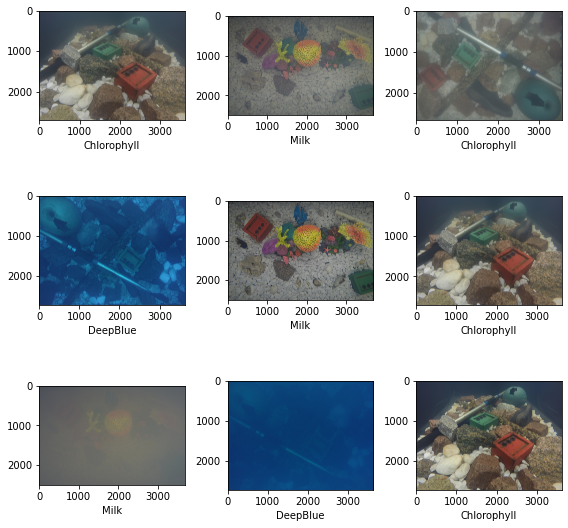

In [ ]:
plot_random_image(imgFilesList, class_labels, labels)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


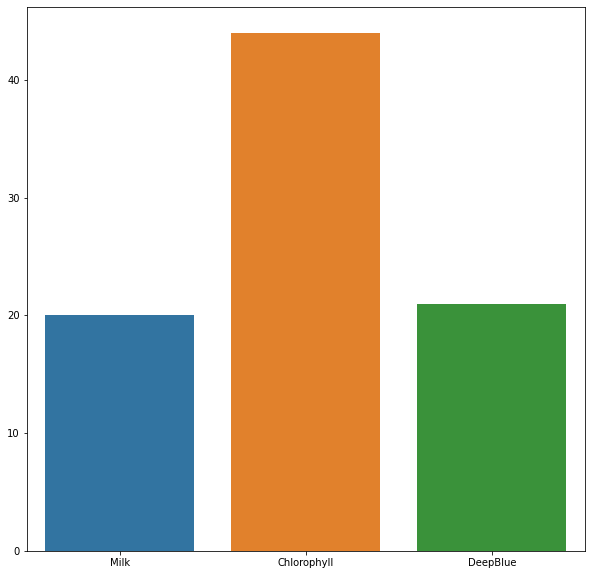

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(labels, count_labels);

In [ ]:
# Transforming and data partition.
# Min-max-scale 
toTensor = tv.transforms.ToTensor()
resize = tv.transforms.Resize((224,224))

def scale_image(x):
    x = resize(x)
    y = toTensor(x)
    if (y.min() < y.max()):
        y = (y-y.min())/(y.max()-y.min())
    z = y - y.mean()
    return z

def transform_(imgFilesList, class_labels):
    img_rescaled = torch.stack([scale_image(Image.open(x)) for x in imgFilesList])
    labels_rescaled = torch.tensor(class_labels)

    print(f'Min pixel value = {img_rescaled.min().item()}; Max = {img_rescaled.min().item()}; Mean = {img_rescaled.mean().item()}')

    return img_rescaled, labels_rescaled

In [ ]:
img_rescaled, labels_rescaled = transform_(imgFilesList, class_labels)


Min pixel value = -0.6831187605857849; Max = -0.6831187605857849; Mean = -1.7363818161086897e-09


In [ ]:

# validation and test set

def num_split_points(total_imgs, fraction = 0.1):
    validList, testList, trainList = [],[],[]

    for data in range(total_imgs):
        # shuffle the dataset
        rn = np.random.random()
        if rn < fraction:
            validList.append(data)
        elif rn < 2*fraction:
            testList.append(data)
        else:
            trainList.append(data)
    return trainList, validList, testList
    

def count_data_items(trainList, validList, testList):
    # length of the split dataset
    ntrain, nvalid, ntest = len(trainList), len(validList), len(testList)
        # output the data shape
    print('Training images = ', ntrain, "Validation = ", nvalid, "Testing = ", ntest)
    return ntrain, nvalid, ntest

def split_data(img_rescaled, labels_rescaled,ntrain, nvalid, ntest):
    
    # id corresponding to the dataset
    trainid, testid, validid = torch.tensor(trainList),\
        torch.tensor(testList), torch.tensor(validList)

    # set of training and test set.
    xtrain = img_rescaled[trainid, :, :, :]
    xtest = img_rescaled[testid, :, :, :]
    xvalid = img_rescaled[validid, :, :, :]
    ytrain = labels_rescaled[trainid]
    ytest = labels_rescaled[testid]
    yvalid = labels_rescaled[validid]


    return xtrain, xtest, xvalid, ytrain, ytest, yvalid

In [ ]:
trainList, validList, testList = num_split_points(total_imgs)

ntrain, nvalid, ntest = count_data_items(trainList, validList, testList)

xtrain, xtest, xvalid, ytrain, ytest, yvalid = split_data(img_rescaled, labels_rescaled, ntrain, nvalid, ntest)

Training images =  71 Validation =  8 Testing =  6
